<a href="https://colab.research.google.com/github/tanvircr7/meh/blob/master/Langgraph_Tutorial_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install -U langgraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 867.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.2/148.2 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 971.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 kB 6.6 MB/s eta 0:00:00


In [2]:
pip install langchain_core langchain-anthropic langgraph langchain-openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.3/245.3 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 20.3 MB/s eta 0:00:00


In [3]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")

OPENAI_API_KEY: ··········


In [4]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [5]:
from langchain.chat_models import init_chat_model

llm = init_chat_model("openai:gpt-3.5-turbo-0125", max_tokens=50)


def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

In [6]:
graph_builder.add_edge(START, "chatbot")

In [7]:
graph_builder.add_edge("chatbot", END)

In [8]:
graph = graph_builder.compile()

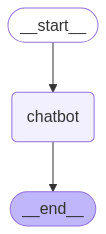

In [9]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [10]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User: 
Assistant: Hello! How can I assist you today?
User: langgraph
Assistant: I'm sorry, but I'm not sure what you mean by "langgraph." Can you please provide more context or clarify your question?
User: What do you know about LangGraph?
Assistant: LangGraph is a language learning platform that uses graph technology to map out language knowledge and help learners track their progress. It offers personalized language learning plans based on individual goals and proficiency levels. Users can practice speaking, listening, reading, and writing in their


# **SEARCH**

In [11]:
!pip install -U langchain-tavily

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 51.1 MB/s eta 0:00:00


In [12]:
_set_env("TAVILY_API_KEY")

TAVILY_API_KEY: ··········


In [13]:
from langchain_tavily import TavilySearch

tool = TavilySearch(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

{'query': "What's a 'node' in LangGraph?",
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': "Introduction to LangGraph: A Beginner's Guide - Medium",
   'url': 'https://medium.com/@cplog/introduction-to-langgraph-a-beginners-guide-14f9be027141',
   'content': 'Stateful Graph: LangGraph revolves around the concept of a stateful graph, where each node in the graph represents a step in your computation, and the graph maintains a state that is passed around and updated as the computation progresses. LangGraph supports conditional edges, allowing you to dynamically determine the next node to execute based on the current state of the graph. We define nodes for classifying the input, handling greetings, and handling search queries. def classify_input_node(state): LangGraph is a versatile tool for building complex, stateful applications with LLMs. By understanding its core concepts and working through simple examples, beginners can start to leverage its powe

In [14]:
from typing import Annotated

from langchain.chat_models import init_chat_model
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


llm = init_chat_model("openai:gpt-3.5-turbo-0125", max_tokens=50)
# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

In [15]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

In [16]:
def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

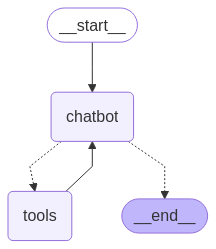

In [17]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [18]:
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User: 
Assistant: Hello! How can I assist you today?
User: What do you know about LangGraph?
Assistant: 
Assistant: {"query": "LangGraph", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://langchain-ai.github.io/langgraph/tutorials/introduction/", "title": "LangGraph Quickstart - GitHub Pages", "content": "[](https://langchain-ai.github.io/langgraph/tutorials/introduction/#__codelineno-9-1)Assistant: LangGraph is a library designed to help build stateful multi-agent applications using language models. It provides tools for creating workflows and state machines to coordinate multiple AI agents or language model interactions. LangGraph is built on top of LangChain, leveraging its components while adding graph-based coordination capabilities. It's particularly useful for developing more complex, [...] [](https://langchain-ai.github.io/langgraph/tutorials/introduction/#__codelineno-21-6)   LangGraph is a library designed for building stateful, multi-ac

# **Memory**

In [51]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [52]:
from typing import Annotated

from langchain.chat_models import init_chat_model
from langchain_tavily import TavilySearch
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearch(max_results=2)
tools = [tool]
llm = init_chat_model("openai:gpt-3.5-turbo-0125", max_tokens=50)
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

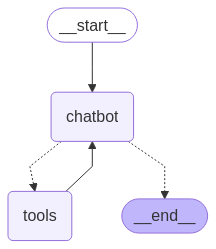

In [53]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [54]:
config = {"configurable": {"thread_id": "2"}}

In [55]:
user_input = "Hi there! My name is Will."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Will.
================================== Ai Message ==================================

Hello Will! How can I assist you today?


In [56]:
user_input = "Remember my name? Say it"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name? Say it
================================== Ai Message ==================================

Of course! Your name is [User's Name].
